<a href="https://colab.research.google.com/github/newbee1905/TrafficFlowPrediction/blob/dev%2Fnewbee1905/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%cd /content
!if [ -d "TrafficFlowPrediction" ]; then rm -rf TrafficFlowPrediction; fi
!git config --global user.name "newbee1905"
!git clone https://github.com/newbee1905/TrafficFlowPrediction -b dev/newbee1905

/content
Cloning into 'TrafficFlowPrediction'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 273 (delta 40), reused 31 (delta 31), pack-reused 222
Receiving objects: 100% (273/273), 27.89 MiB | 21.28 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [4]:
%cd TrafficFlowPrediction
!pip install -r requirements.txt

/content/TrafficFlowPrediction
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.8/181.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.7/798.7 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.6/254.6 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 63.4 MB/s eta 0:00:00
    

In [15]:
!python train.py --all --epoch 1800

Streaming output truncated to the last 5000 lines.
Epoch 125/1800
35/35 [==============================] - 1s 35ms/step - loss: 0.0012 - mape: 142061.2812 - val_loss: 0.0011 - val_mape: 134922.7969 - lr: 0.0010
Epoch 126/1800
35/35 [==============================] - 1s 34ms/step - loss: 0.0012 - mape: 152994.2812 - val_loss: 0.0011 - val_mape: 146392.6875 - lr: 0.0010
Epoch 128/1800
35/35 [==============================] - 1s 35ms/step - loss: 0.0012 - mape: 142102.3125 - val_loss: 0.0011 - val_mape: 137573.1719 - lr: 0.0010
Epoch 127/1800
35/35 [==============================] - 1s 35ms/step - loss: 0.0012 - mape: 151448.4688 - val_loss: 0.0011 - val_mape: 145893.1875 - lr: 0.0010
Epoch 129/1800
35/35 [==============================] - 1s 37ms/step - loss: 0.0012 - mape: 140833.0469 - val_loss: 0.0011 - val_mape: 136301.6875 - lr: 0.0010
Epoch 128/1800
35/35 [==============================] - 1s 37ms/step - loss: 0.0012 - mape: 153338.2812 - val_loss: 0.0011 - val_mape: 148099.2656 - 

In [6]:
import math
import warnings
import numpy as np
import pandas as pd
from data.data import process_data
from keras.models import load_model
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
warnings.filterwarnings("ignore")

In [10]:
def MAPE(y_true, y_pred):
    """Mean Absolute Percentage Error
    Calculate the mape.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    # Returns
        mape: Double, result data for train.
    """

    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape

In [8]:
def eva_regress(y_true, y_pred):
    """Evaluation
    evaluate the predicted resul.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    """

    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)

In [9]:
def plot_results(y_true, y_preds, names, periods):
    """Plot
    Plot the true data and predicted data.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
        names: List, Method names.
    """
    d = '2006-10-01 00:00'
    y_true = y_true[:periods]
    x = pd.date_range(d, periods=periods, freq='15min')

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(names, y_preds):
        ax.plot(x, y_pred, label=name)

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()


    now = datetime.now()
    current_time = now.strftime("%m-%d-%Y-%H-%M-%S")
    plt.savefig(f'output-{current_time}.png', dpi=2400)

    plt.show()


In [16]:
lstm = load_model('model/lstm.h5')
gru = load_model('model/gru.h5')
saes = load_model('model/saes.h5')
models = [lstm, gru]
names = ['LSTM', 'GRU']

lag = 7
file = 'data/Scats Data October 2006.xls'
_, _, X_test, y_test, flow_scaler, flow_rescaler = process_data(file, lag)
y_test = np.vectorize(flow_rescaler)(y_test)

days = 1
hours = 24
periods = days * hours * 60 // 15
y_preds = []
for name, model in zip(names, models):
    if name == 'SAEs':
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
    else:
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    file = 'images/' + name + '.png'
    plot_model(model, to_file=file, show_shapes=True)
    predicted = model.predict(X_test)
    predicted = np.vectorize(flow_rescaler)(predicted)
    y_preds.append(predicted[:periods])
    print(name)
    eva_regress(y_test, predicted)

3137/3137 [==============================] - 10s 3ms/step
LSTM
explained_variance_score:0.943009
mape:28.124077%
mae:13.697882
mse:430.101049
rmse:20.738878
r2:0.943004
3137/3137 [==============================] - 8s 3ms/step
GRU
explained_variance_score:0.942973
mape:28.411831%
mae:13.714740
mse:430.351942
rmse:20.744926
r2:0.942971


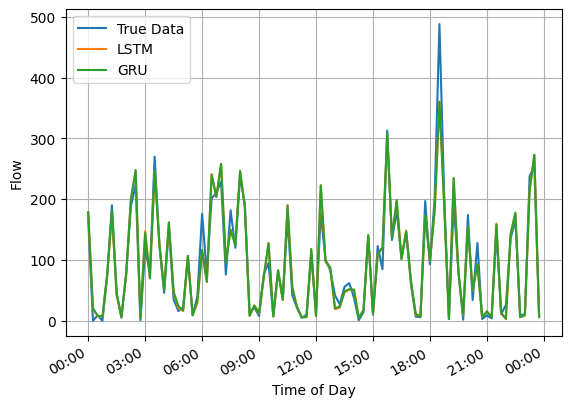

In [17]:
plot_results(y_test, y_preds, names, periods)